This notebook is a simple walkthrough of using PyHyperScattering to work through RSoXS data taken on the SST-1 beamline.

Important things first: PyHyper is an in-development library, in the 0.x version scheme, so things can shift at any time.  That said, we try not to change the API for anything but the most critical reasons.  It also means that errors should be reported using the 'issues' feature on the project github, here: https://github.com/usnistgov/pyhyperscattering

The library has a few discrete modules:

1) File loaders.  These abstract away the details of getting raw data into a raw xarray and correcting the intensity (which lives here because it tends ot be metadata-intensive).  To add support for a new beamline you simply write a class that inherits from FileLoader with one method that opens the file, formats it into an xarray, and cleans up the metadata to include standard terms like exposure, energy, pos_x, pos_th, etc.

(optionally, data preprocessors like HDRSoXS exposure stitching can live between these two steps.)

2) Integrators.  These abstract away the details of conversion from a raw xarray to a chi,q xarray.  I provide a pyFAI based general purpose integrator (no parameters change within an array) and an energy series integrator (energy changes in an array and is handled efficiently).  Implementing other geometries (e.g. a detector moving) would be handled by subclassing the general integrator.  Implementing other backends (for example, pyGix) is also easy by just supporting the same integrateSingleImage(img) and integrateImageStack(img_stack) methods.

(you can slice the data here easily with standard xarray selector methods - as demonstrated below - or process it)

3) Fitting.  The fits are very simple to write, I provide a few demos here for lorentz and gauss peaks.  I think there are better curve fitting backends than scipy.optimize.curve_fit (lm_fit?) but that's what I used.


In [3]:
!pip install --upgrade pyhyperscattering

     |████████████████████████████████| 44 kB 1.8 MB/s eta 0:00:011


First, we import the modules we're going to use:

In [4]:
import PyHyperScattering

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl

/srv/conda/envs/notebook/lib/python3.7/site-packages/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator
/srv/conda/envs/notebook/lib/python3.7/site-packages/PyHyperScattering/util.py:4: UserWarning: Could not import package for interactive integration utils.  Install holoviews and scikit-image.
  from PyHyperScattering import IntegrationUtils


PyHyper provides two loaders that work for SST1 RSoXS data: SST1RSoXSLoader (for files) and SST1RSoXSDB (for live-loading from DataBroker, on-site at NSLS2, via jupyter.nsls2.bnl.gov, or soon via tiled.nsls2.bnl.gov.

You can look at the initialization options and initialize like so (press shift-tab to view the inline documentation for the init function)

In [8]:

file_loader = PyHyperScattering.load.SST1RSoXSLoader(corr_mode='none')

db_loader = PyHyperScattering.load.SST1RSoXSDB(corr_mode='none')

OBJECT CACHE: Will use up to 121_499_070_873 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_070_873 bytes (15% of total physical RAM)


Let's load a RSoXS scan.  This will be a little different for file-loader and for DataBroker.  I'll go through each.

DataBroker first.

In [7]:
from tiled.client import from_profile

c = from_profile('rsoxs')

OBJECT CACHE: Will use up to 121_499_070_873 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_070_873 bytes (15% of total physical RAM)


c is the databroker catalog object, a dictionary-like structure that has access to all RSoXS data.  You can access a run from it using the run-id (a 5-digit scan number), like so:

In [9]:
c[36146]

<BlueskyRun {'baseline', 'RSoXS Sample Current_monitor', 'RSoXS Slit 1 In Board Current_monitor', 'en_monoen_readback_monitor', 'primary', 'RSoXS Slit 1 Bottom Current_monitor', 'SAXS Beamstop_monitor', 'dark', 'NSLS-II Ring Current_monitor', 'RSoXS Slit 1 Out Board Current_monitor', 'RSoXS Au Mesh Current_monitor', 'WAXS Beamstop_monitor', 'RSoXS Slit 1 Top Current_monitor', 'RSoXS Shutter Toggle_monitor'} scan_id=36146 uid='780a59f0' 2021-12-15 15:39>

This BlueskyRun object is a deep tree of all the instrument data/metadata/etc from your scan.  We want it in a usable, PyHyper-compatible form, so we just tell PyHyper to load a scan from it:

The one mandatory argument is dims, this is the dimension along which the scan varies.  It might be energy, or position, or any other dimension.  PyHyper is used for all kinds of multivariate scattering data.  Mostly, it'll be 'energy'

In [14]:
scan = db_loader.loadRun(c[36106],dims=['energy'])
scan

<xarray.DataArray 'Wide Angle CCD Detector_image' (system: 128, pix_y: 1024, pix_x: 1026)>
array([[[  0,  -6,   3, ..., -11,  -5,   5],
        [ -4,  20,  -8, ...,   7,   5,  -3],
        [ 10, -17,   0, ...,   7, -10,   4],
        ...,
        [ 19,   2,  -4, ...,  -1,  -4,  10],
        [ -5,   0,   7, ...,  -2,  19,   8],
        [  8, -12,  14, ...,   5,  14,  -1]],

       [[  2,   1,  -2, ..., -11,  -9,   5],
        [  0,  30,  17, ..., -19,   0,   2],
        [ 10, -20,   3, ...,  21,   3,  14],
        ...,
        [  8,  29,   2, ...,  -8, 117,   0],
        [ -8,   0,  -4, ...,  -4,  13,  10],
        [ -2,  -4,   8, ...,   5,   6,  -7]],

       [[  0,  -3,  -2, ...,  -8,  -5,   4],
        [  1,  30,   2, ..., -12,   1,   6],
        [  1,  -1,  22, ...,  16,  11,   7],
        ...,
...
        ...,
        [ -8,   0,  21, ...,  15,  15,  26],
        [ 21,   6,  63, ..., -23,  25,  -1],
        [ 17, -24,   8, ...,   7, -15,  16]],

       [[  3,   4,  -5, ...,   4,  -8,  -4],
        [ 24,  -8,  15, ...,  23,  18,  14],
        [ -9,  43,  -1, ...,   6,  -5,  -3],
        ...,
        [  7,   4,  -7, ...,   1,  16,  17],
        [ 24,   0,   1, ..., -23,  -3, -12],
        [ 16,  -7,  -3, ...,   7,   0,   1]],

       [[  5,  16,  -3, ...,  12,  -3,  -1],
        [ -4,  -9,  38, ...,  15,  17,   6],
        [ 13, -18,   3, ...,   0,   1,   0],
        ...,
        [ -4,  58,  30, ..., -10,  35,  21],
        [ 11,  18,  50, ..., -19, -12, -26],
        [  1,  -8,   5, ...,   5, -10,  13]]])
Coordinates:
    dark_id  (system) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 6.0 6.0 6.0 6.0 6.0
  * system   (system) MultiIndex
  - energy   (system) float64 270.0 270.5 271.0 271.5 ... 335.0 340.0 345.0
  * pix_x    (pix_x) int64 0 1 2 3 4 5 6 ... 1019 1020 1021 1022 1023 1024 1025
  * pix_y    (pix_y) int64 0 1 2 3 4 5 6 ... 1017 1018 1019 1020 1021 1022 1023
Attributes: (12/26)
    meas_time:     2021-12-15 12:19:55.598514
    sample_name:   CB_PLA_D18h
    rsoxs_config:  waxs
    beamcenter_x:  397
    beamcenter_y:  535.6
    sdd:           36.7
    ...            ...
    rot1:          0
    rot2:          0
    rot3:          0
    start:         {'uid': '8a8ffcae-8884-4820-ba4d-7ee00ab8d544', 'time': 16...
    stop:          {'run_start': '8a8ffcae-8884-4820-ba4d-7ee00ab8d544', 'tim...
    summary:       {'uid': '8a8ffcae-8884-4820-ba4d-7ee00ab8d544', 'scan_id':...

Now, from files:

You'll need to modify this path to some RSoXS data on disk.  If you don't have any, feel free to skip ahead, or download some from the example data pack on the GitHub repo (look under releases).

In [18]:
demo = file_loader.loadFileSeries('/nsls2/data/sst1/legacy/RSoXS/analysis/example_suitcased_data/24587/',['energy','polarization'])

Found 66 files.


  0%|          | 0/66 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.7/site-packages/PyHyperScattering/FileLoader.py:108: UserWarning: Loader does not support features for args: dict_keys(['image_slice', 'use_cached_md'])
  img = self.loadSingleImage(basepath/file,coords=local_coords, return_q = output_qxy,image_slice=image_slice,use_cached_md=True)


Loaded 55/66 files


Just as from databroker, we get an xarray.  You'll notice that here we gave it 'polarization' as a dimension too... useful for stacking data later.

In [19]:
demo

<xarray.DataArray (system: 55, pix_x: 1024, pix_y: 1026)>
array([[[  7.,  13., -16., ...,   9., -14., -14.],
        [-16.,  -9.,  16., ...,  -4., -10.,  -9.],
        [ -1., -12., -13., ...,   7.,  17.,   8.],
        ...,
        [ -5., -10.,  21., ...,  -2.,  10.,   3.],
        [  1.,  -4.,  15., ...,   3.,  26., -18.],
        [ 18.,   6.,   2., ...,  11.,  -2.,  -4.]],

       [[  7.,  -3., -10., ...,  12.,   3.,   0.],
        [ -2.,  -1.,  -4., ...,   1.,   2.,  -7.],
        [  9., -16.,  -6., ...,  11.,  10.,  -2.],
        ...,
        [ 44., -18.,  18., ...,   3.,  -3.,  -2.],
        [ -2.,   2.,  22., ...,   7.,  12.,  -7.],
        [  3.,   6.,   7., ...,   8.,  12.,   7.]],

       [[ 11.,   6.,  36., ...,  10.,   6., -13.],
        [-11.,   4.,  22., ...,   6.,  17., -15.],
        [ 17.,  -1., -12., ...,   1.,  37.,  -6.],
        ...,
...
        ...,
        [-12.,  -8.,  13., ...,   8.,  10.,   6.],
        [ 13.,  -9.,  -1., ...,   5.,   2., -14.],
        [ 21.,  10.,   7., ...,   8., -13.,  -1.]],

       [[  2.,  20., -12., ...,  13.,  -3., -11.],
        [  2.,   8.,  -9., ...,  35.,   1., -14.],
        [  0., -21.,  -4., ...,   8.,  19.,   7.],
        ...,
        [  2.,  -3.,  22., ...,   5.,   3.,   5.],
        [ 64.,  -3.,  13., ...,  -3.,   9.,   0.],
        [ 14., -11.,  -3., ...,   6.,   5.,   9.]],

       [[  2.,  15., -15., ...,  12.,  -2.,  -7.],
        [ 13.,   9., -10., ..., -11.,  -9., -15.],
        [  3., -10., -10., ...,  14.,  18.,   4.],
        ...,
        [ -4.,  13.,  12., ...,  20.,   3.,  -8.],
        [ -5.,  -5.,  22., ...,  -3.,  11.,  -8.],
        [  5.,  -4.,   4., ...,   3., -14.,   3.]]])
Coordinates:
  * system        (system) MultiIndex
  - energy        (system) float64 270.0 272.0 284.0 284.5 ... 282.5 283.0 283.5
  - polarization  (system) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * pix_x         (pix_x) int64 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * pix_y         (pix_y) int64 0 1 2 3 4 5 6 ... 1020 1021 1022 1023 1024 1025
Attributes: (12/24)
    exposure:       2000
    energy:         270.0
    polarization:   0
    sam_x:          9.1713
    sam_y:          -114.0105
    sam_z:          0.0
    ...             ...
    poni1:          0.03186
    poni2:          0.02403
    rot1:           0
    rot2:           0
    rot3:           0
    dims_unpacked:  ['energy', 'polarization']

Integration
------------


No matter which path we took, we now have a raw xarray.  This commonality is key - it lets PyHyper merge data from different instruments and even simulations and use a common language to slice and analyze it all.



In [25]:
if demo.rsoxs_config == 'waxs':
    maskmethod = 'nika'
    mask = '/nsls2/data/sst1/legacy/RSoXS/analysis/SST1_WAXS_mask.hdf'
elif demo.rsoxs_config == 'saxs':
    maskmethod = 'nika'
    mask = '/nsls2/data/sst1/legacy/RSoXS/analysis/SST1-SAXS_mask.hdf'
else:
    maskmethod = 'none'

integ = PyHyperScattering.integrate.PFEnergySeriesIntegrator(maskmethod=maskmethod,
                                                             maskpath=mask,
                                                             geomethod='template_xr',
                                                             template_xr=demo,
                                                             integration_method='csr_ocl')

Imported Nika mask of type h5, dimensions (1024, 1026)


Just as with the loader, we set up an integrator object.  This one has a few more parameters, mostly to set the masking and beam center etc.  In this case we're using a shared mask on the analysis cluster and pulling the geometry from our template xarray.

We can load masks and geometry from Nika, too.

Integration is a single command:

In [27]:
integrated_data = integ.integrateImageStack(demo)

  0%|          | 0/55 [00:00<?, ?it/s]

Just as before, we can do that with either array:

In [34]:
if demo.rsoxs_config == 'waxs':
    maskmethod = 'nika'
    mask = '/nsls2/data/sst1/legacy/RSoXS/analysis/SST1_WAXS_mask.hdf'
elif demo.rsoxs_config == 'saxs':
    maskmethod = 'nika'
    mask = '/nsls2/data/sst1/legacy/RSoXS/analysis/SST1-SAXS_mask.hdf'
else:
    maskmethod = 'none'

integ_db = PyHyperScattering.integrate.PFEnergySeriesIntegrator(maskmethod=maskmethod,
                                                             maskpath=mask,
                                                             geomethod='template_xr',
                                                             template_xr=scan,
                                                             integration_method='csr_ocl')

integrated_scan = integ_db.integrateImageStack(scan)

Imported Nika mask of type h5, dimensions (1024, 1026)


  0%|          | 0/128 [00:00<?, ?it/s]

We now have an integrated xarray.  We integrate the data into an unmeshed chi-q map.

One feature/annoyance is that the energy axis is stacked into something called 'system'.  This is computationally needed for multidimensional axes, but a bit of a pain for us now.  Let's clean it up:

In [35]:
integrated_scan = integrated_scan.unstack('system')
integrated_scan

<xarray.DataArray (chi: 360, q: 500, energy: 128)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * chi      (chi) float64 -179.5 -178.5 -177.5 -176.5 ... 177.4 178.4 179.4
  * q        (q) float64 0.000251 0.0005115 0.000772 ... 0.1297 0.13 0.1302
  * energy   (energy) float64 270.0 270.5 271.0 271.5 ... 335.0 340.0 345.0
Attributes: (12/26)
    meas_time:     2021-12-15 12:19:55.598514
    sample_name:   CB_PLA_D18h
    rsoxs_config:  waxs
    beamcenter_x:  397
    beamcenter_y:  535.6
    sdd:           36.7
    ...            ...
    rot1:          0
    rot2:          0
    rot3:          0
    start:         {'uid': '8a8ffcae-8884-4820-ba4d-7ee00ab8d544', 'time': 16...
    stop:          {'run_start': '8a8ffcae-8884-4820-ba4d-7ee00ab8d544', 'tim...
    summary:       {'uid': '8a8ffcae-8884-4820-ba4d-7ee00ab8d544', 'scan_id':...

This can be sliced in various ways to make handy RSoXS plots... but first, let's import some MatPlotLib tools.

In [38]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'CB_PLA_D18h @ 270 eV')

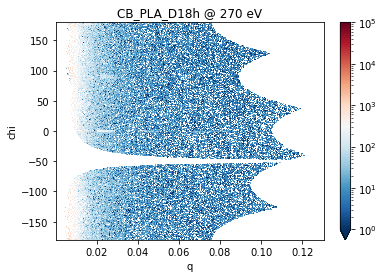

In [41]:
integrated_scan.sel(energy=270).plot(norm=LogNorm(1,1e5))
plt.title(f'{integrated_scan.sample_name} @ 270 eV')

We can sum this data-cube, in addition to just selecting items.  Suppose we want a circular average...

Text(0.5, 1.0, 'CB_PLA_D18h IqE')

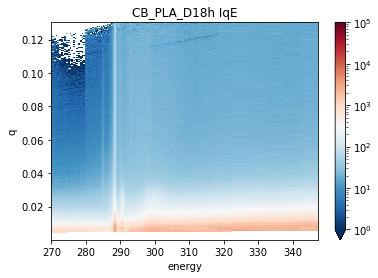

In [43]:
integrated_scan.mean('chi').plot(norm=LogNorm(1,1e5))
plt.title(f'{integrated_scan.sample_name} IqE')

We can go a step further and automatically compute AR:

Text(0.5, 1.0, 'CB_PLA_D18h AR')

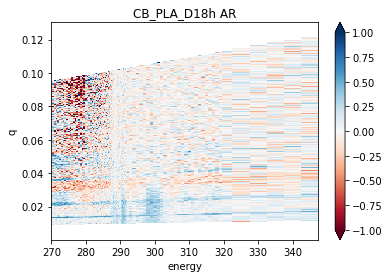

In [45]:
integrated_scan.rsoxs.AR().plot(vmin=-1,vmax=1,cmap='RdBu')
plt.title(f'{integrated_scan.sample_name} AR')

Almost any analysis can be written using combinations of .sel().mean() and various custom slicing functions.

As an example, here's the simplified source code for rsoxs.AR():

In [47]:
    def AR(self,chi_width=5):
        '''
        Calculate the RSoXS Anisotropic Ratio (AR) of either a single RSoXS scan or a polarized pair of scans.
        AR is defined as (para-perp)/(para+perp) where para is the chi slice parallel to the polarization direction, and perp is the chi slice 90 deg offset from the polarization direction.
        Args:
            img (xarray): image to plot
            calc2d (bool): calculate the AR using both polarizations
            two_AR (bool): return both polarizations if calc2d = True.  If two_AR = False, return the average AR between the two polarizations.
            calc2d_norm_energy (numeric): if set, normalizes each polarization's AR at a given energy.  THIS EFFECTIVELY FORCES THE AR TO 0 AT THIS ENERGY.
        '''
        para = self.slice_chi(0,chi_width=chi_width)
        perp = self.slice_chi(-90,chi_width=chi_width)
        return ((para - perp) / (para+perp))

As an exercise, let's try plotting I(q) for a wedge about 0:

In [50]:
integrated_scan.rsoxs.slice_chi(0)

<xarray.DataArray (q: 500, energy: 128)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., 17.48750171,
        16.12710977, 16.37260328],
       [        nan,         nan,         nan, ...,  8.7902233 ,
        16.74126388, 18.26598472],
       [        nan,         nan,         nan, ..., 13.29268977,
        19.48564651, 20.77537617]])
Coordinates:
  * q        (q) float64 0.000251 0.0005115 0.000772 ... 0.1297 0.13 0.1302
  * energy   (energy) float64 270.0 270.5 271.0 271.5 ... 335.0 340.0 345.0

This is now intensity vs. q and energy... so if we select a single energy, we get I(q):
    
    (you might need to add method='nearest' to the select, due to floating-point errors)

In [55]:
integrated_scan.rsoxs.slice_chi(0).sel(energy=270,method='nearest')

<xarray.DataArray (q: 500)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, 296.88058203, 473.37060464,
       360.20247053, 251.01024769, 277.8514493 , 218.59876956,
       204.42464018, 254.33597125, 212.27377193, 254.27264596,
       180.34530291, 188.54238084, 190.81467705, 185.88090035,
       203.98503879, 494.37607249, 558.85178363, 542.2461006 ,
       182.5587707 , 136.61223059, 118.36804329, 106.99044118,
       120.95935176, 119.60924494, 112.30844931,  98.37971682,
        77.48654755,  80.21027648,  90.07654178,  68.44349554,
        79.96351897,  66.53830822,  65.56371326,  76.12483267,
        75.0723436 ,  65.4913945 ,  23.41771909,  73.92448442,
        45.00210777,  70.07473397,  43.88110843,  50.02821689,
        54.75647056, 108.95678392, 139.40422545, 138.03984328,
...
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan])
Coordinates:
  * q        (q) float64 0.000251 0.0005115 0.000772 ... 0.1297 0.13 0.1302
    energy   float64 270.0

And we can just take that command and add .plot() to the end to draw a plot:

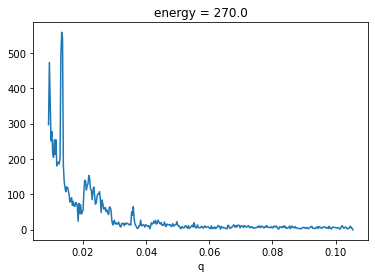

In [56]:
integrated_scan.rsoxs.slice_chi(0).sel(energy=270,method='nearest').plot()

We can give .plot() normal matplotlib arguments to make this plot a bit more scattering-y...

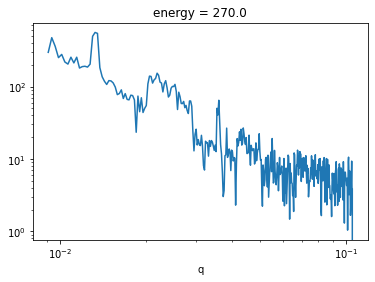

In [58]:
integrated_scan.rsoxs.slice_chi(0).sel(energy=270,method='nearest').plot(xscale='log',yscale='log')

OK, so what if we want to do this in a different axis... say a chi plot in a ring?  Just change the slicing!

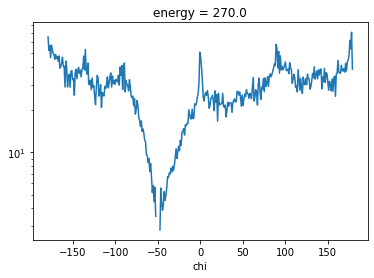

In [63]:
integrated_scan.sel(energy=270,method='nearest').sel(q=slice(0,1)).mean('q').plot(yscale='log')

Can you follow what happened there?  Try deleting commands from the end of the stack and looking at the intermediate output to follow the pipeline.

We can even plot things that make image plots.  Say, if we want to understand why these results are weird:

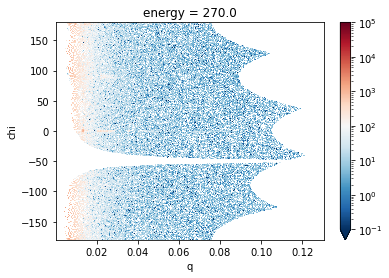

In [67]:
integrated_scan.sel(energy=270,method='nearest').plot(norm=LogNorm(0.1,1e5))

One more feature.  Even though these are separate images, energy is just another axis.  What about ISI, total intensity vs energy? Try to write it yourself.

Here's the solution:

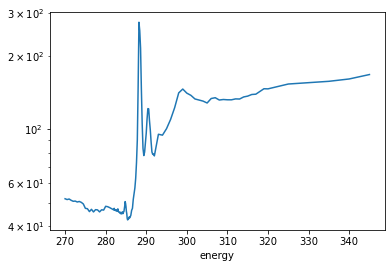

In [70]:
integrated_scan.mean('chi').mean('q').plot(yscale='log')

There are (or will be) other modules for more advanced analyses - fitting, etc.  Check them out!